In this notebook named 'Ciclo_2' we are going to adress the main notebook's issue where the frequency encoder required by 'nameDest' column demands high memory usage of Heroku cloud, causing error when trying to acesses model's predictions. Here we will evaluate wheter the removal of this feature compromises model's performance. Therefore, we removed most of the subtopics discussed in main notebook, going straight to the point where we retrain and evaluate the new model.

# <font face="Arial" color="green">Library Imports</font>

In [2]:
import time
import warnings
import random
import requests
import pickle
import bz2
import _pickle                   as cPickle
import pandas                    as pd
import numpy                     as np
import matplotlib.pyplot         as plt
import seaborn                   as sns
import scipy.stats               as stats
import xgboost                   as xgb

from math                        import ceil
from math                        import floor
from IPython.display             import Image
from sklearn.model_selection     import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing       import RobustScaler, LabelEncoder
from sklearn.ensemble            import RandomForestClassifier
from sklearn.linear_model        import LogisticRegression
from sklearn.neighbors           import KNeighborsClassifier
from sklearn                     import metrics
from boruta                      import BorutaPy

from pycorrcat.pycorrcat         import plot_corr, corr_matrix

warnings.filterwarnings("ignore")

# <font face="Arial" color="green">Helper functions</font>

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None   
    


warnings.filterwarnings("ignore")
jupyter_settings()



def get_model_metrics(model_name, model, X_train, y_train, X_test, y_test):
    
    

    inst_model = model.fit(X_train, y_train)


    y_pred = inst_model.predict(X_test)


    # Metrics:



    # Accuracy

    print('Accuracy: {}\n'.format(round(metrics.accuracy_score(y_test, y_pred),3)))


    # Balanced Accuracy

    print('Balanced Accuracy: {}\n'.format(round(metrics.balanced_accuracy_score(y_test, y_pred),3)))


    # AUC ROC


    # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1) <- sintax

    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                             np.array([i[1] for i in inst_model.predict_proba(X_test)]), 
                                             pos_label=1)

    metrics.auc(fpr, tpr)

    print('AUC-ROC: {}\n'.format(round(metrics.auc(fpr, tpr),3)))


    # Classification report

    print('Classification report:\n\n {}\n'.format(metrics.classification_report(y_test, y_pred)))


    # Gathering metrics for this estimator

    inst_model_accuracy = metrics.accuracy_score(y_test, y_pred)

    inst_model_bal_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)

    inst_model_auc = metrics.auc(fpr, tpr)

    inst_model_precision = metrics.precision_score(y_test, y_pred)

    inst_model_f1 = metrics.f1_score(y_test, y_pred)

    inst_model_recall = metrics.recall_score(y_test, y_pred)
    
    
    
    # Getting df
    
    
    df = pd.DataFrame(data=[model_name, inst_model_accuracy,
                            inst_model_bal_accuracy, 
                            inst_model_auc, 
                            inst_model_precision, 
                            inst_model_f1, 
                            inst_model_recall]).transpose()

    df.columns = ['Model name', 'Accuracy', 'Balanced Accuracy', 'AUC', 'Precision', 'F1-score', 'Recall']
    
    return df    

# 7- Machine Learning

In [18]:
# Loading stored scaled train dataset

X_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/X_train.pkl', 'rb'))

y_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_train.pkl', 'rb'))

X_test = pickle.load(open('/mnt/d/Gustavo/fraud-detection/X_test.pkl', 'rb'))

y_test = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_test.pkl', 'rb'))


In [19]:
print("Features selected by Boruta:\n ['step', 'type', 'amount', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'day_of_month', 'oldbalanceDest_status_non-zero', 'newbalanceDest_status_non-zero', 'newbalanceDest_status_zero', 'hour_of_day_sin', 'hour_of_day_cos']")
print('\n')
print("Features not selected by Boruta:\n ['period_of_day_cos', 'time_of_day_AM', 'is_weekend_weekdays', 'period_of_day_sin', 'dest_type_Costumer', 'oldbalanceOrg_status_zero', 'isFlaggedFraud_yes', 'day_of_week_sin', 'newbalanceOrig', 'time_of_day_PM', 'is_oldbalanceDest_higherthan_newbalanceDest_no', 'isFlaggedFraud_no', 'newbalanceOrig_status_zero', 'week_of_month', 'transaction_direction_C2C', 'is_weekend_weekend', 'dest_type_Merchant', 'is_oldbalanceOrg_higherthan_newbalanceOrig_yes', 'is_oldbalanceDest_higherthan_newbalanceDest_yes', 'newbalanceOrig_status_non-zero', 'oldbalanceOrg_status_non-zero', 'is_oldbalanceOrg_higherthan_newbalanceOrig_no', 'transaction_direction_C2M', 'day_of_week_cos', 'oldbalanceDest_status_zero']")

Features selected by Boruta:
 ['step', 'type', 'amount', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'day_of_month', 'oldbalanceDest_status_non-zero', 'newbalanceDest_status_non-zero', 'newbalanceDest_status_zero', 'hour_of_day_sin', 'hour_of_day_cos']


Features not selected by Boruta:
 ['period_of_day_cos', 'time_of_day_AM', 'is_weekend_weekdays', 'period_of_day_sin', 'dest_type_Costumer', 'oldbalanceOrg_status_zero', 'isFlaggedFraud_yes', 'day_of_week_sin', 'newbalanceOrig', 'time_of_day_PM', 'is_oldbalanceDest_higherthan_newbalanceDest_no', 'isFlaggedFraud_no', 'newbalanceOrig_status_zero', 'week_of_month', 'transaction_direction_C2C', 'is_weekend_weekend', 'dest_type_Merchant', 'is_oldbalanceOrg_higherthan_newbalanceOrig_yes', 'is_oldbalanceDest_higherthan_newbalanceDest_yes', 'newbalanceOrig_status_non-zero', 'oldbalanceOrg_status_non-zero', 'is_oldbalanceOrg_higherthan_newbalanceOrig_no', 'transaction_direction_C2M', 'day_of_week_cos', 'oldbalanceDest_status

In [20]:
# Columns selected by Boruta (column nameDest removed - frequency encoder requires too much from Heroku)

cols_selected_boruta = X_train.loc[:, [True, True, True, True, False, False, True, True, True, False, False, False,
                                       False, False, False, False, False, False, False, False, False, False, True,
                                       False, True, True, False, False, False, False, False, False, True, True,
                                       False, False, False, False]].columns.tolist()

In [21]:
# Defining datasets with Boruta-selected features (without 'NameDest column')


# X_train
X_train_boruta = X_train[cols_selected_boruta].copy()


# X_test
X_test_boruta = X_test[cols_selected_boruta].copy()



## <font face="Arial" color="gray">7.1 Baseline model</font>

In [154]:
# Random model - setting

target_variables_list = y_train.unique().tolist() # target variables (class 0=non-Fraud, 1=Fraud)

k_num = y_test.shape[0] # k number of values to sample from (number of rows in y_test)

class_weights = y_test.value_counts(normalize=True).tolist() # proportion of samples of each class


# Random model

y_pred = random.choices(population=target_variables_list , weights=class_weights, k=k_num)


# Metrics: ========================================================================

print('Accuracy: {}\n'.format(round(metrics.accuracy_score(y_test, y_pred),3)))

print('Balanced Accuracy: {}\n'.format(round(metrics.balanced_accuracy_score(y_test, y_pred),3)))


# AUC ROC


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1) <- sintax

fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                         np.array(y_pred), 
                                         pos_label=1)

metrics.auc(fpr, tpr)

print('AUC-ROC: {}\n'.format(round(metrics.auc(fpr, tpr),3)))




print('Classification report:\n\n {}'.format(metrics.classification_report(y_test, y_pred)))


# Gathering metrics for this estimator =============================================

baseline_accuracy = metrics.accuracy_score(y_test, y_pred)

baseline_bal_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)

baseline_auc = metrics.auc(fpr, tpr)

baseline_precision = metrics.precision_score(y_test, y_pred)

baseline_f1 = metrics.f1_score(y_test, y_pred)

baseline_recall = metrics.recall_score(y_test, y_pred)



df_baseline = pd.DataFrame(data=['Baseline Model', baseline_accuracy, baseline_bal_accuracy, baseline_auc, baseline_precision, baseline_f1, baseline_recall]).transpose()

df_baseline.columns = ['Model name', 'Accuracy', 'Balanced Accuracy', 'AUC', 'Precision', 'F1-score', 'Recall']

df_baseline

Accuracy: 0.997

Balanced Accuracy: 0.5

AUC-ROC: 0.5

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.00      0.00      0.00      2666

    accuracy                           1.00   2099665
   macro avg       0.50      0.50      0.50   2099665
weighted avg       1.00      1.00      1.00   2099665



,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Baseline Model,0.997404,0.499523,0.499523,0.000359,0.000367,0.000375


## <font face="Arial" color="gray">7.4 XGBoost</font>

In [159]:


model_name = 'XG Boost'

model = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            max_depth=10,
                            tree_method='exact',
                            n_jobs=-1,
                            random_state=42)


df_xgb = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_xgb

Accuracy: 1.0

Balanced Accuracy: 0.913

AUC-ROC: 0.998

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.99      0.83      0.90      2666

    accuracy                           1.00   2099665
   macro avg       0.99      0.91      0.95   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,XG Boost,0.999763,0.912596,0.998484,0.986105,0.898509,0.825206


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

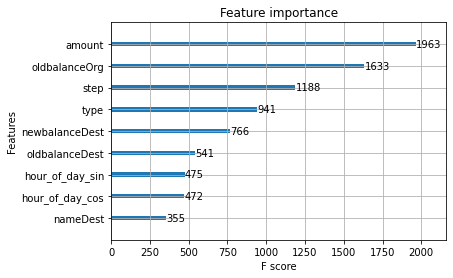

In [160]:
xgb.plot_importance(model)

In [9]:
# XG Boost without 'nameDest'

model_name = 'XG Boost'

model = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            max_depth=10,
                            tree_method='exact',
                            n_jobs=-1,
                            random_state=42)


df_xgb = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_xgb

Accuracy: 1.0

Balanced Accuracy: 0.914

AUC-ROC: 0.999

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.98      0.83      0.90      2666

    accuracy                           1.00   2099665
   macro avg       0.99      0.91      0.95   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,XG Boost,0.999766,0.91447,0.998712,0.98441,0.90002,0.828957


##  <font color=blue><i>Cross-validation</i></font>

Cross-validation results for the previous XGBoost model:

In [25]:
# Cross-validation - XG Boost

# Metrics to search
list_metrics_to_search = ['accuracy','balanced_accuracy', 'roc_auc', 'precision', 'f1', 'recall']


# Creating a empty df
df_metrics_cv = pd.DataFrame(columns=list_metrics_to_search) # columns
df_metrics_cv = df_metrics_cv.append({'accuracy': np.nan}, ignore_index=True) # filling the first row with NA
df_metrics_cv.index = ['XG Boost'] # setting the string 'XG Boost' as df index


# Instantiating the classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=100,
                          max_depth=10,
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42)

# Setting the folds (shuffle=True due to imbalance in dataset)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# loop for metrics evaluation within cross-validation
for i in list_metrics_to_search:
    
    print('Now evaluating: {}'.format(i))
    
    
    results_cv = cross_val_score(model, X_train_boruta, y_train, cv=kfold, n_jobs=-1, verbose=1, scoring=i)
    
    print('Evaluation of {} status: Done'.format(i))
    
    
    print('Inserting {} results information to table'.format(i))
    
    df_metrics_cv[i] = str(round(results_cv.mean(), 2))+' +/-'+str(round(results_cv.std(), 2))
    
    print('Insertion done.\n')
    
    print('{}\n'.format(df_metrics_cv))
    
    
print('Metrics calculation fisinhed.\n')


print('Stratified k-fold Cross-validation results:')
df_metrics_cv


Now evaluating: accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.1min finished


Evaluation of accuracy status: Done
Inserting accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0               NaN     NaN       NaN  NaN    NaN

Now evaluating: balanced_accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.9min finished


Evaluation of balanced_accuracy status: Done
Inserting balanced_accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01     NaN       NaN  NaN    NaN

Now evaluating: roc_auc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.0min finished


Evaluation of roc_auc status: Done
Inserting roc_auc results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0       NaN  NaN    NaN

Now evaluating: precision


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.1min finished


Evaluation of precision status: Done
Inserting precision results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  NaN    NaN

Now evaluating: f1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.1min finished


Evaluation of f1 status: Done
Inserting f1 results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision           f1  \
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  0.9 +/-0.01   

         recall  
XG Boost    NaN  

Now evaluating: recall


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.0min finished


Evaluation of recall status: Done
Inserting recall results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision           f1  \
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  0.9 +/-0.01   

                recall  
XG Boost  0.83 +/-0.02  

Metrics calculation fisinhed.

Stratified k-fold Cross-validation results:


,accuracy,balanced_accuracy,roc_auc,precision,f1,recall
XG Boost,1.0 +/-0.0,0.91 +/-0.01,1.0 +/-0.0,0.98 +/-0.01,0.9 +/-0.01,0.83 +/-0.02


Cross-validation results for the newly evaluated XGBoost model (without 'nameDest' column):

In [94]:
# Cross-validation - XG Boost

# Metrics to search
list_metrics_to_search = ['accuracy','balanced_accuracy', 'roc_auc', 'precision', 'f1', 'recall']


# Creating a empty df
df_metrics_cv = pd.DataFrame(columns=list_metrics_to_search) # columns
df_metrics_cv = df_metrics_cv.append({'accuracy': np.nan}, ignore_index=True) # filling the first row with NA
df_metrics_cv.index = ['XG Boost'] # setting the string 'XG Boost' as df index


# Instantiating the classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=100,
                          max_depth=10,
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42)

# Setting the folds (shuffle=True due to imbalance in dataset)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# loop for metrics evaluation within cross-validation
for i in list_metrics_to_search:
    
    print('Now evaluating: {}'.format(i))
    
    
    results_cv = cross_val_score(model, X_train_boruta, y_train, cv=kfold, n_jobs=-1, verbose=1, scoring=i)
    
    print('Evaluation of {} status: Done'.format(i))
    
    
    print('Inserting {} results information to table'.format(i))
    
    df_metrics_cv[i] = str(round(results_cv.mean(), 2))+' +/-'+str(round(results_cv.std(), 2))
    
    print('Insertion done.\n')
    
    print('{}\n'.format(df_metrics_cv))
    
    
print('Metrics calculation fisinhed.\n')


print('Stratified k-fold Cross-validation results:')
df_metrics_cv


Now evaluating: accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.8min finished


Evaluation of accuracy status: Done
Inserting accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0               NaN     NaN       NaN  NaN    NaN

Now evaluating: balanced_accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.5min finished


Evaluation of balanced_accuracy status: Done
Inserting balanced_accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01     NaN       NaN  NaN    NaN

Now evaluating: roc_auc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.9min finished


Evaluation of roc_auc status: Done
Inserting roc_auc results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0       NaN  NaN    NaN

Now evaluating: precision


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.1min finished


Evaluation of precision status: Done
Inserting precision results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  NaN    NaN

Now evaluating: f1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.0min finished


Evaluation of f1 status: Done
Inserting f1 results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision           f1  \
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  0.9 +/-0.01   

         recall  
XG Boost    NaN  

Now evaluating: recall


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.2min finished


Evaluation of recall status: Done
Inserting recall results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision           f1  \
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  0.9 +/-0.01   

                recall  
XG Boost  0.83 +/-0.02  

Metrics calculation fisinhed.

Stratified k-fold Cross-validation results:


,accuracy,balanced_accuracy,roc_auc,precision,f1,recall
XG Boost,1.0 +/-0.0,0.91 +/-0.01,1.0 +/-0.0,0.98 +/-0.01,0.9 +/-0.01,0.83 +/-0.02


As you can see the results for stratified k-fold cross-validation did not differ from the previous to the newly trained model, meaning that the removel of the column 'nameDest' does not degradete model's performance. For this reason, in the Hiperparameter fine tuning session we are not going to re-evaluate hyperparameters, instead we are going to use the previously tuned hyperparameters.

#  8- Hiperparameter fine tuning

##  <font face="Arial" color="gray">8.1 <font><i>Random search</i></font></font>

Random search evaluation can be acessed in the main notebook.

##  <font face="Arial" color="gray">8.2 <font><i>Tuned final model</i></font></font>

In [17]:
# Setting parameters

best_parameters = {'n_estimators': 85, 
                   'max_depth': 15, 
                   'learning_rate': 0.8, 
                   'subsample': 0.7, 
                   'colsample_bytree': 0.9, 
                   'min_child_weight': 5}

best_parameters

{'n_estimators': 85,
 'max_depth': 15,
 'learning_rate': 0.8,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'min_child_weight': 5}

In [111]:
# Cross validation - Previous tuned model


# Metrics to search
list_metrics_to_search = ['accuracy','balanced_accuracy', 'roc_auc', 'precision', 'f1', 'recall']


# Creating a empty df
df_metrics_cv = pd.DataFrame(columns=list_metrics_to_search) # columns
df_metrics_cv = df_metrics_cv.append({'accuracy': np.nan}, ignore_index=True) # filling the first row with NA
df_metrics_cv.index = ['XG Boost'] # setting the string 'XG Boost' as df index


# Instantiating the tuned classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=best_parameters['n_estimators'],
                          max_depth=best_parameters['max_depth'],
                          learning_rate=best_parameters['learning_rate'],
                          subsample=best_parameters['subsample'],
                          colsample_bytree=best_parameters['colsample_bytree'],
                          min_child_weight=best_parameters['min_child_weight'],
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42
                         )

# Setting the folds (shuffle=True due to imbalance in dataset)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# loop for metrics evaluation within cross-validation
for i in list_metrics_to_search:
    
    print('Now evaluating: {}'.format(i))
    
    
    results_cv = cross_val_score(model, X_train_boruta, y_train, cv=kfold, n_jobs=-1, verbose=1, scoring=i)
    
    print('Evaluation of {} status: Done'.format(i))
    
    
    print('Inserting {} results information to table'.format(i))
    
    df_metrics_cv[i] = str(round(results_cv.mean(), 2))+' +/-'+str(round(results_cv.std(), 2))
    
    print('Insertion done.\n')
    
    print('{}\n'.format(df_metrics_cv))
    
    
print('Metrics calculation fisinhed.\n')


print('Stratified k-fold Cross-validation results:')
df_metrics_cv


Now evaluating: accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.4min finished


Evaluation of accuracy status: Done
Inserting accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0               NaN     NaN       NaN  NaN    NaN

Now evaluating: balanced_accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.2min finished


Evaluation of balanced_accuracy status: Done
Inserting balanced_accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.92 +/-0.01     NaN       NaN  NaN    NaN

Now evaluating: roc_auc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.0min finished


Evaluation of roc_auc status: Done
Inserting roc_auc results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0       NaN  NaN    NaN

Now evaluating: precision


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.9min finished


Evaluation of precision status: Done
Inserting precision results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision   f1 recall
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0  0.95 +/-0.01  NaN    NaN

Now evaluating: f1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.0min finished


Evaluation of f1 status: Done
Inserting f1 results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision  \
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0  0.95 +/-0.01   

                    f1 recall  
XG Boost  0.89 +/-0.01    NaN  

Now evaluating: recall


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.8min finished


Evaluation of recall status: Done
Inserting recall results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision  \
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0  0.95 +/-0.01   

                    f1        recall  
XG Boost  0.89 +/-0.01  0.84 +/-0.01  

Metrics calculation fisinhed.

Stratified k-fold Cross-validation results:


,accuracy,balanced_accuracy,roc_auc,precision,f1,recall
XG Boost,1.0 +/-0.0,0.92 +/-0.01,1.0 +/-0.0,0.95 +/-0.01,0.89 +/-0.01,0.84 +/-0.01


In [22]:
# Cross validation - Newly tuned model


# Metrics to search
list_metrics_to_search = ['accuracy','balanced_accuracy', 'roc_auc', 'precision', 'f1', 'recall']


# Creating a empty df
df_metrics_cv = pd.DataFrame(columns=list_metrics_to_search) # columns
df_metrics_cv = df_metrics_cv.append({'accuracy': np.nan}, ignore_index=True) # filling the first row with NA
df_metrics_cv.index = ['XG Boost'] # setting the string 'XG Boost' as df index


# Instantiating the tuned classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=best_parameters['n_estimators'],
                          max_depth=best_parameters['max_depth'],
                          learning_rate=best_parameters['learning_rate'],
                          subsample=best_parameters['subsample'],
                          colsample_bytree=best_parameters['colsample_bytree'],
                          min_child_weight=best_parameters['min_child_weight'],
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42
                         )

# Setting the folds (shuffle=True due to imbalance in dataset)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# loop for metrics evaluation within cross-validation
for i in list_metrics_to_search:
    
    print('Now evaluating: {}'.format(i))
    
    
    results_cv = cross_val_score(model, X_train_boruta, y_train, cv=kfold, n_jobs=-1, verbose=1, scoring=i)
    
    print('Evaluation of {} status: Done'.format(i))
    
    
    print('Inserting {} results information to table'.format(i))
    
    df_metrics_cv[i] = str(round(results_cv.mean(), 2))+' +/-'+str(round(results_cv.std(), 2))
    
    print('Insertion done.\n')
    
    print('{}\n'.format(df_metrics_cv))
    
    
print('Metrics calculation fisinhed.\n')


print('Stratified k-fold Cross-validation results:')
df_metrics_cv


Now evaluating: accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.0min finished


Evaluation of accuracy status: Done
Inserting accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0               NaN     NaN       NaN  NaN    NaN

Now evaluating: balanced_accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.6min finished


Evaluation of balanced_accuracy status: Done
Inserting balanced_accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.92 +/-0.01     NaN       NaN  NaN    NaN

Now evaluating: roc_auc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.6min finished


Evaluation of roc_auc status: Done
Inserting roc_auc results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0       NaN  NaN    NaN

Now evaluating: precision


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.6min finished


Evaluation of precision status: Done
Inserting precision results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision   f1 recall
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0  0.96 +/-0.01  NaN    NaN

Now evaluating: f1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.5min finished


Evaluation of f1 status: Done
Inserting f1 results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision  \
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0  0.96 +/-0.01   

                    f1 recall  
XG Boost  0.89 +/-0.01    NaN  

Now evaluating: recall


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 36.7min finished


Evaluation of recall status: Done
Inserting recall results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision  \
XG Boost  1.0 +/-0.0      0.92 +/-0.01  1.0 +/-0.0  0.96 +/-0.01   

                    f1        recall  
XG Boost  0.89 +/-0.01  0.84 +/-0.02  

Metrics calculation fisinhed.

Stratified k-fold Cross-validation results:


,accuracy,balanced_accuracy,roc_auc,precision,f1,recall
XG Boost,1.0 +/-0.0,0.92 +/-0.01,1.0 +/-0.0,0.96 +/-0.01,0.89 +/-0.01,0.84 +/-0.02


In [17]:
# Training the model to predict unseen data - previous model

model_name = 'XG Boost'

model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=best_parameters['n_estimators'],
                          max_depth=best_parameters['max_depth'],
                          learning_rate=best_parameters['learning_rate'],
                          subsample=best_parameters['subsample'],
                          colsample_bytree=best_parameters['colsample_bytree'],
                          min_child_weight=best_parameters['min_child_weight'],
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42
                         )


# model performance (unseen data)
df_xgb_final = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_xgb_final

Accuracy: 1.0

Balanced Accuracy: 0.92

AUC-ROC: 0.998

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.95      0.84      0.89      2666

    accuracy                           1.00   2099665
   macro avg       0.98      0.92      0.95   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,XG Boost,0.99974,0.919702,0.998481,0.950318,0.891456,0.83946


In [100]:
# Fitting and saving the final model (Without 'nameDest' column)


best_parameters = {'n_estimators': 85, 
                   'max_depth': 15, 
                   'learning_rate': 0.8, 
                   'subsample': 0.7, 
                   'colsample_bytree': 0.9, 
                   'min_child_weight': 5}



# Instantiating the tuned classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=best_parameters['n_estimators'],
                          max_depth=best_parameters['max_depth'],
                          learning_rate=best_parameters['learning_rate'],
                          subsample=best_parameters['subsample'],
                          colsample_bytree=best_parameters['colsample_bytree'],
                          min_child_weight=best_parameters['min_child_weight'],
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42
                         )

# Fitting the classifier

model.fit(X_train_boruta, y_train)


XGBClassifier(colsample_bytree=0.9, learning_rate=0.8, max_depth=15,
              min_child_weight=5, n_estimators=85, n_jobs=-1, random_state=42,
              subsample=0.7, tree_method='exact')

In [101]:
# Metrics of tuned model (Without 'nameDest' column)

df_xgb = get_model_metrics('XGBoost', model, X_train_boruta, y_train, X_test_boruta, y_test)


df_xgb

Accuracy: 1.0

Balanced Accuracy: 0.921

AUC-ROC: 0.998

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.96      0.84      0.90      2666

    accuracy                           1.00   2099665
   macro avg       0.98      0.92      0.95   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,XGBoost,0.99975,0.920643,0.997875,0.956503,0.89523,0.841335


In [15]:
print(model)

# Saving fitted model - Final model (Without 'nameDest' column)
cPickle.dump(model, bz2.BZ2File('/mnt/d/Gustavo/fraud-detection/modelXGBoost.pbz2', 'w'))

XGBClassifier(colsample_bytree=0.9, learning_rate=0.8, max_depth=15,
              min_child_weight=5, n_estimators=85, n_jobs=-1, random_state=42,
              subsample=0.7, tree_method='exact')


#  9- Error interpretation

## <font face="Arial" color="gray">9.1 Main</font>

Here we are going to use the test dataset as external data and the final model to make predictions to compare both true and predicted values to make possible calculations for business purposes. 

In [102]:
# Loading X_test and y_test (scaled) and X_test  and y_test (unscaled)

X_test = pickle.load(open('/mnt/d/Gustavo/fraud-detection/X_test.pkl', 'rb'))

y_test = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_test.pkl', 'rb'))

X_test_raw = pd.read_csv('/mnt/d/Gustavo/fraud-detection/X_test.csv')

y_test_raw = pd.read_csv('/mnt/d/Gustavo/fraud-detection/y_test.csv')


# Loading y_test (to use for baseline model business calculations)

y_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_train.pkl', 'rb'))


# Loading fitted ML XGBoost model

model = cPickle.load(bz2.BZ2File('/mnt/d/Gustavo/fraud-detection/modelXGBoost.pbz2', 'rb'))

In [103]:
X_train

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
1186641,132,CASH_IN,186994.49,C320666714,4980.00,191974.49,C1638234085,2565463.66,2225790.42,0
1199598,133,CASH_OUT,86377.61,C305317239,31480.00,0.00,C1726047166,0.00,86377.61,0
1185636,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0
6211424,588,TRANSFER,697319.21,C1191381567,25493.00,0.00,C233809815,2150239.95,2847559.16,0
4452703,323,PAYMENT,59243.58,C2024305751,29879.00,0.00,M336524512,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
1570006,155,CASH_IN,129715.85,C170740978,5054252.83,5183968.68,C1810492506,246692.94,116977.09,0
2234489,186,PAYMENT,2459.70,C1844108072,0.00,0.00,M1858126655,0.00,0.00,0
4926484,350,CASH_OUT,10579.16,C1579684659,59279.00,48699.84,C1119180135,322754.16,333333.32,0
4304572,307,CASH_OUT,73020.76,C379222646,20289.00,0.00,C1962227951,256102.84,329123.61,0


In [104]:
# Columns selected by Boruta - Without 'nameDest' column

cols_selected_boruta = X_test.loc[:, [True, True, True, True, False, False, True, True, True, False, False, False,
                                       False, False, False, False, False, False, False, False, False, False, True,
                                       False, True, True, False, False, False, False, False, False, True, True,
                                       False, False, False, False]].columns.tolist()

In [105]:
# Defining datasets with Boruta-selected features


# X_test
X_test_boruta = X_test[cols_selected_boruta].copy()



In [106]:
# Adding 'isFraud' column to the end of X_test_raw

X_test_raw = pd.concat([X_test_raw, y_test_raw], axis=1)



In [107]:
# Adding 'Predictions' column to the end of X_test_raw

X_test_raw['Predictions'] = model.predict(X_test_boruta)

In [108]:
X_test_raw.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,day_of_month,week_of_month,hour_of_day,day_of_week,is_weekend,time_of_day,period_of_day,dest_type,oldbalanceOrg_status,newbalanceOrig_status,oldbalanceDest_status,newbalanceDest_status,is_oldbalanceOrg_higherthan_newbalanceOrig,is_oldbalanceDest_higherthan_newbalanceDest,transaction_direction,isFraud,Predictions
0,278,CASH_IN,330218.42,20866.00,351084.42,C834976624,452419.57,122201.15,no,12,2,13,5,weekdays,PM,Afternoon,Costumer,non-zero,non-zero,non-zero,non-zero,no,yes,C2C,0,0
1,15,PAYMENT,11647.08,30370.00,18722.92,M215391829,0.00,0.00,no,1,1,14,1,weekend,PM,Afternoon,Merchant,non-zero,non-zero,zero,zero,yes,no,C2M,0,0
2,10,CASH_IN,152264.21,106589.00,258853.21,C1607284477,201303.01,49038.80,no,1,1,9,1,weekend,AM,Morning,Costumer,non-zero,non-zero,non-zero,non-zero,no,yes,C2C,0,0
3,403,TRANSFER,1551760.63,0.00,0.00,C1564353608,3198359.45,4750120.08,no,17,3,18,3,weekdays,PM,Afternoon,Costumer,zero,zero,non-zero,non-zero,no,no,C2C,0,0
4,206,CASH_IN,78172.30,2921331.58,2999503.88,C1091768874,415821.90,337649.60,no,9,2,13,2,weekdays,PM,Afternoon,Costumer,non-zero,non-zero,non-zero,non-zero,no,yes,C2C,0,0


## <font face="Arial" color="gray">9.2 Business performance</font>

Here is important to remind about the business model of our fictious company (how the company actually makes money). The  Transaction Tracker trackers bank transactions to check for any kind of fraud. Revenue stream information can be found as follows:

- For <font color=red><b>fraudulent</b></font> transactions correctly detected by the model, 25% of the amount of the corresponding transactions goes to Transaction Tracker as payment.

- For <font color=green><b>non-fraudulent</b></font> transactions detected by the model as fraud, 25% of the amount of the corresponding transactions goes to Transaction Tracker.

- For <font color=red><b>fraudulent</b></font> transactions wrongfully detected as non-fraud, the Transaction Tracker must 100% refund the victim of fraud.

Now we are going to compare the old previously trained model with the newly trained one from the business standpoint looking out for the profit.

Old model - with 'nameDest' column

In [155]:

print('\nRevenue:')

# Amount of money involved fraudulent transactions that were correctly detected my the model


print('\nSum of amount of fraudulent transactions correctly detected by Transaction Tracker: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)))


# 25% of this amount goes to Transaction Tracker as payment


print('\nTransaction Tracker amount received for detecting fraudulent transactions (25%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2)))


# Amount of money involved non-fraudulent transactions that detected my the model as fraud


print('\nSum of amount of non-fraudulent transactions detected by Transaction Tracker as fraud: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)))


# 5% of this amount goes to Transaction Tracker as payment


print('\nTransaction Tracker amount received for this transaction operation (5%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))


# Amount of money involved fraudulent transactions that were wrongfully detected my the model as non-fraud


print('\nSum of amount of fraudulent transactions  wrongfully detected by Transaction Tracker as non-fraud: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2)))


# 100% of this amount goes back to fraud victim as refund from Transaction Tracker


print('\nTransaction Tracker refound cashback (-100%): ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2)))


print('\n\nProfit:')

print('\n(25%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2)))

print('\n+(5%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))

print('\n-(100%): ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2)))

print('-'*30)

print('\nTotal profit: ${:,}'.format(round((round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2) + round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)) - round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2),2) ))



Revenue:

Sum of amount of fraudulent transactions correctly detected by Transaction Tracker: $3,719,735,063.56

Transaction Tracker amount received for detecting fraudulent transactions (25%): $929,933,765.89

Sum of amount of non-fraudulent transactions detected by Transaction Tracker as fraud: $27,691,057.44

Transaction Tracker amount received for this transaction operation (5%): $1,384,552.87

Sum of amount of fraudulent transactions  wrongfully detected by Transaction Tracker as non-fraud: $85,846,430.44

Transaction Tracker refound cashback (-100%): $85,846,430.44


Profit:

(25%): $929,933,765.89

+(5%): $1,384,552.87

-(100%): $85,846,430.44
------------------------------

Total profit: $845,471,888.32


New model - without 'nameDest' column

In [91]:

print('\nRevenue:')

# Amount of money involved fraudulent transactions that were correctly detected my the model


print('\nSum of amount of fraudulent transactions correctly detected by Transaction Tracker: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)))


# 25% of this amount goes to Transaction Tracker as payment


print('\nTransaction Tracker amount received for detecting fraudulent transactions (25%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2)))


# Amount of money involved non-fraudulent transactions that detected my the model as fraud


print('\nSum of amount of non-fraudulent transactions detected by Transaction Tracker as fraud: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)))


# 5% of this amount goes to Transaction Tracker as payment


print('\nTransaction Tracker amount received for this transaction operation (5%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))


# Amount of money involved fraudulent transactions that were wrongfully detected my the model as non-fraud


print('\nSum of amount of fraudulent transactions  wrongfully detected by Transaction Tracker as non-fraud: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2)))


# 100% of this amount goes back to fraud victim as refund from Transaction Tracker


print('\nTransaction Tracker refound cashback (-100%): ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2)))


print('\n\nProfit:')

print('\n(25%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2)))

print('\n+(5%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))

print('\n-(100%): ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2)))

print('-'*30)

print('\nTotal profit: ${:,}'.format(round((round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2) + round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)) - round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==0), 'amount'].sum(), 2),2) ))



Revenue:

Sum of amount of fraudulent transactions correctly detected by Transaction Tracker: $3,727,842,474.35

Transaction Tracker amount received for detecting fraudulent transactions (25%): $931,960,618.59

Sum of amount of non-fraudulent transactions detected by Transaction Tracker as fraud: $24,622,407.99

Transaction Tracker amount received for this transaction operation (5%): $1,231,120.4

Sum of amount of fraudulent transactions  wrongfully detected by Transaction Tracker as non-fraud: $77,739,019.65

Transaction Tracker refound cashback (-100%): $77,739,019.65


Profit:

(25%): $931,960,618.59

+(5%): $1,231,120.4

-(100%): $77,739,019.65
------------------------------

Total profit: $855,452,719.34


Here it was possible to note that, aside from ease model deployment, the removal of the column 'nameDest' even increased Transaction Tracker's profit.

 Now we are going to point out the advantages for client that hires the service provided by Transaction Tracker. We will assume for this scenario that the hiring client uses the baseline model.

In [92]:
# Random model - setting

target_variables_list = y_train.unique().tolist() # target variables (class 0=non-Fraud, 1=Fraud)

k_num = y_test.shape[0] # k number of values to sample from (number of rows in y_test)

class_weights = y_test.value_counts(normalize=True).tolist() # proportion of samples of each class


# Random model

y_pred = random.choices(population=target_variables_list , weights=class_weights, k=k_num)


# Adding column 'Predictions_baseline_model' to X_test_raw datset

X_test_raw['Predictions_baseline_model'] = y_pred

Old model - with 'nameDest' column

In [154]:
print('\nBaseline model')


print('\nSum of amount of fraudulent transactions correctly detected by baseline model: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==1), 'amount'].sum(), 2)))

print('\nSum of amount of fraudulent transactions wrongfully detected by baseline model as non-fraud: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==0), 'amount'].sum(), 2)))



print('\n\nExpenses (loss) calculation:\n')

print('\nWithout hiring Transaction Tracker services: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==0), 'amount'].sum(), 2)))


print('\nHiring Transaction Tracker services:\n')

print('\n(25%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2)))

print('\n+(5%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))

print('-'*30)

print('\nSum: ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2) + round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))

print('\n\nTotal saved by hiring Transaction Tracker services: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==0), 'amount'].sum(), 2) - round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2) + round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))



Baseline model

Sum of amount of fraudulent transactions correctly detected by baseline model: $1,789,207.89

Sum of amount of fraudulent transactions wrongfully detected by baseline model as non-fraud: $3,803,792,286.11


Expenses (loss) calculation:


Without hiring Transaction Tracker services: $3,803,792,286.11

Hiring Transaction Tracker services:


(25%): $929,933,765.89

+(5%): $1,384,552.87
------------------------------

Sum: $931,318,318.76


Total saved by hiring Transaction Tracker services: $2,875,243,073.09


New model - without 'nameDest' column

In [93]:
print('\nBaseline model')


print('\nSum of amount of fraudulent transactions correctly detected by baseline model: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==1), 'amount'].sum(), 2)))

print('\nSum of amount of fraudulent transactions wrongfully detected by baseline model as non-fraud: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==0), 'amount'].sum(), 2)))



print('\n\nExpenses (loss) calculation:\n')

print('\nWithout hiring Transaction Tracker services: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==0), 'amount'].sum(), 2)))


print('\nHiring Transaction Tracker services:\n')

print('\n(25%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2)))

print('\n+(5%): ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))

print('-'*30)

print('\nSum: ${:,}'.format(round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2) + round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))

print('\n\nTotal saved by hiring Transaction Tracker services: ${:,}'.format(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions_baseline_model']==0), 'amount'].sum(), 2) - round(round(X_test_raw.loc[(X_test_raw['isFraud']==1) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.25,2) + round(round(X_test_raw.loc[(X_test_raw['isFraud']==0) & (X_test_raw['Predictions']==1), 'amount'].sum(), 2)*0.05,2)))



Baseline model

Sum of amount of fraudulent transactions correctly detected by baseline model: $2,443,622.9

Sum of amount of fraudulent transactions wrongfully detected by baseline model as non-fraud: $3,803,137,871.1


Expenses (loss) calculation:


Without hiring Transaction Tracker services: $3,803,137,871.1

Hiring Transaction Tracker services:


(25%): $931,960,618.59

+(5%): $1,231,120.4
------------------------------

Sum: $933,191,738.99


Total saved by hiring Transaction Tracker services: $2,872,408,372.91


Here we conclude that the improvent of model performance represents more expenses for the hiring client. It is reasonable considering that now they would be paying for a more qualified service. Even so the amount of money saved represents a huge advantage over baseline model.

## <font face="Arial" color="gray">9.3 Machine learning performance</font>

Old model - with 'nameDest' column

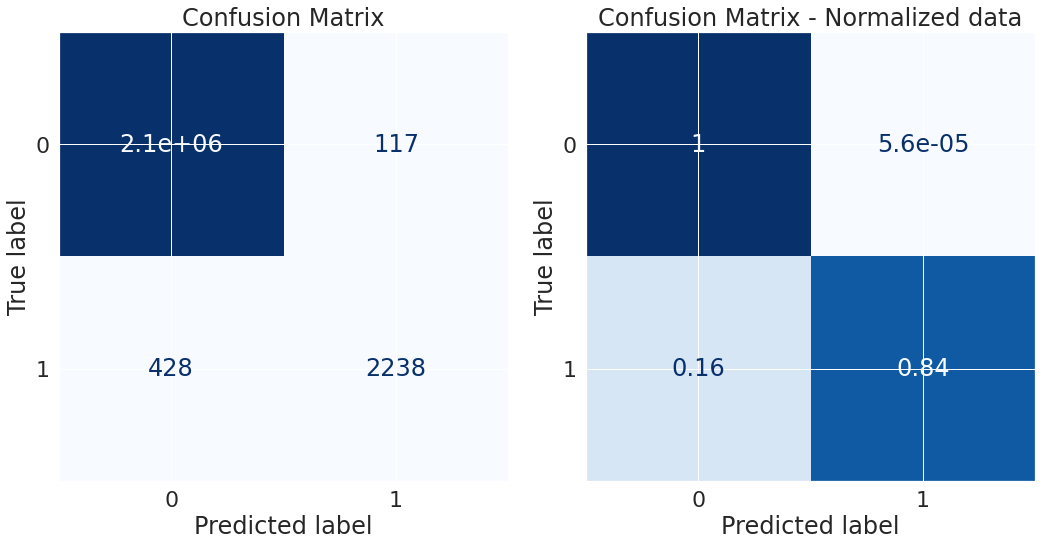

In [92]:

# Summary of metrics ============================================================================


sns.set(font_scale=2.0)

# Confusion matrix curve


plt.figure(figsize=(15,10))

# raw

ax1 = plt.subplot(1,2,1)

ax1.set_title('Confusion Matrix')

cm1 = metrics.plot_confusion_matrix(model, X_test_boruta, y_test, ax=ax1, colorbar=False, cmap='Blues')




# normalized

ax2 = plt.subplot(1,2,2)

ax2.set_title('Confusion Matrix - Normalized data')

cm2 = metrics.plot_confusion_matrix(model, X_test_boruta, y_test, normalize='true', ax=ax2, colorbar=False, cmap='Blues');



plt.tight_layout()

New model - without 'nameDest' column

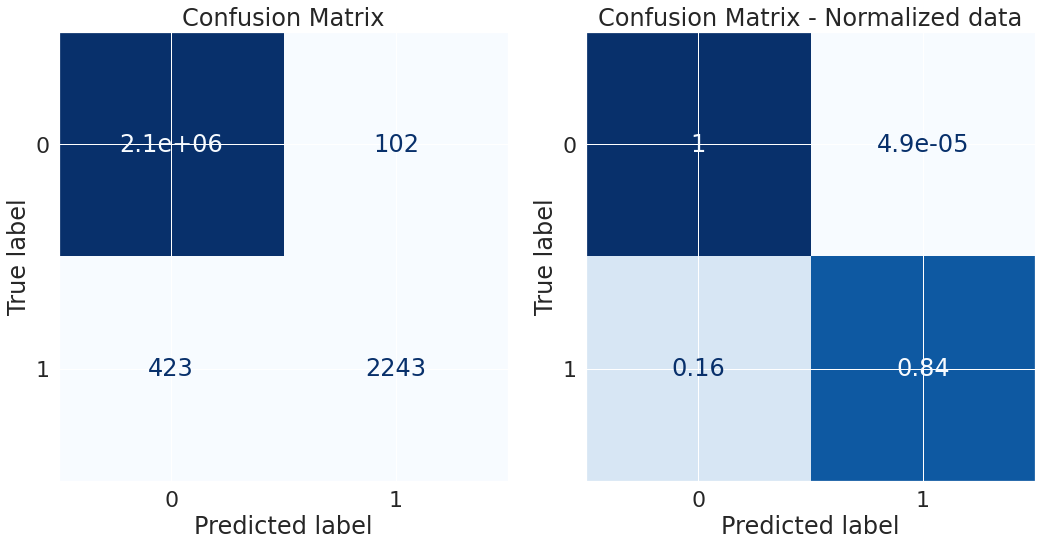

In [109]:

# Summary of metrics ============================================================================


sns.set(font_scale=2.0)

# Confusion matrix curve


plt.figure(figsize=(15,10))

# raw

ax1 = plt.subplot(1,2,1)

ax1.set_title('Confusion Matrix')

cm1 = metrics.plot_confusion_matrix(model, X_test_boruta, y_test, ax=ax1, colorbar=False, cmap='Blues')




# normalized

ax2 = plt.subplot(1,2,2)

ax2.set_title('Confusion Matrix - Normalized data')

cm2 = metrics.plot_confusion_matrix(model, X_test_boruta, y_test, normalize='true', ax=ax2, colorbar=False, cmap='Blues');



plt.tight_layout()

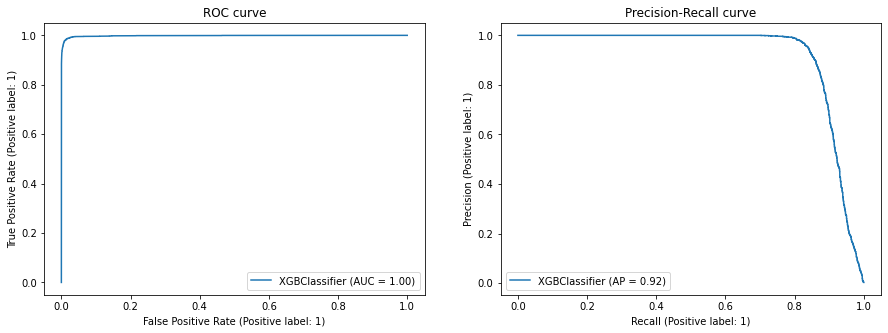

In [79]:
plt.figure(figsize=(15,5))


# ROC curve

ax3 = plt.subplot(1,2,1)

ax3.set_title('ROC curve')

metrics.plot_roc_curve(model, X_test_boruta, y_test, ax=ax3);





# Precision-Recall curve

ax4 = plt.subplot(1,2,2)

ax4.set_title('Precision-Recall curve')

metrics.plot_precision_recall_curve(model, X_test_boruta, y_test, ax=ax4);


#  10- Model deployment

## <font face="Arial" color="gray">10.1 Class Fraud - Data_prep.py</font>

In [ ]:
import pickle
import bz2
import _pickle as cPickle
from math                        import ceil
from math                        import floor
import pandas as pd
import numpy as np
import json



class Data_prep(object):
    
    def __init__(self):        
        self.amount_scaler          =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/amount_scaler.pkl', 'rb')) # Opening scaler        
        self.day_of_month_scaler    =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/day_of_month_scaler.pkl', 'rb')) # Opening scaler        
        self.newbalanceDest_scaler  =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/newbalanceDest_scaler.pkl', 'rb')) # Opening scaler
                
        self.newbalanceOrig_scaler  =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/newbalanceOrig_scaler.pkl', 'rb')) # Opening scaler        
        self.oldbalanceDest_scaler  =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/oldbalanceDest_scaler.pkl', 'rb')) # Opening scaler        
        self.oldbalanceOrg_scaler   =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/oldbalanceOrg_scaler.pkl', 'rb')) # Opening scaler        
        self.step_scaler            =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/step_scaler.pkl', 'rb')) # Opening scaler        
        self.type_encoder           =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/type_encoder.pkl', 'rb')) # Opening encoder        
        self.week_of_month_scaler   =  pickle.load(open('/mnt/d/Gustavo/fraud-detection/week_of_month_scaler.pkl', 'rb')) # Opening scaler
    
    
    
    def feature_engineering(self, df1):
                
        # Day of month

        df1['day_of_month'] = df1['step'].apply(lambda x: ceil(x/24))
        
        # Week of month

        df1['week_of_month'] = df1['step'].apply(lambda x: ceil(x/168))
        
        # Creating aux column 'min_step_of_day'

        for i in df1['day_of_month'].unique():
            df1.loc[df1['day_of_month']==i,'min_step_of_day'] = df1.loc[df1['day_of_month']==i, 'step'].min()
        
        
        # Creating 'hour_of_day' column

        df1['hour_of_day'] = df1['step'] - df1['min_step_of_day']
        
        
        # Creating aux column 'min_day_of_week'

        for i in df1['week_of_month'].unique():
            df1.loc[df1['week_of_month']==i, 'min_day_of_week'] = df1.loc[df1['week_of_month']==i, 'day_of_month'].min()


        # Creating 'day_of_week' column
        
        df1['day_of_week'] = ((df1['day_of_month'] - df1['min_day_of_week'])+1)
        
        
        # Creating 'is_weekend' column

        df1['is_weekend'] = df1['day_of_week'].apply(lambda x: 'weekend' if x == 1 or x == 7 else 'weekdays')
        
        
        # Creating 'time_of_day' column

        df1['time_of_day'] = df1['hour_of_day'].apply(lambda x: 'AM' if x <= 12 else 'PM')
        
        
        # Creating 'period_of_day' column

        df1['period_of_day'] = ['Morning' if i<=12 else 'Afternoon' if i>12 and i<=18 else 'Evening' for i in df1['hour_of_day']]
        
        
        # Creating 'orig_type' column

        df1['orig_type'] = ['Merchant' if i[0]== 'M' else 'Costumer' for i in df1['nameOrig']]
        
        
        # Creating 'dest_type' column

        df1['dest_type'] = ['Merchant' if i[0]== 'M' else 'Costumer' for i in df1['nameDest']]
        
        
        # Creating 'oldbalanceOrg_status'

        df1['oldbalanceOrg_status'] = ['zero' if i==0 else 'non-zero' for i in df1['oldbalanceOrg']]
        
        
        # Creating 'newbalanceOrig_status'

        df1['newbalanceOrig_status'] = ['zero' if i==0 else 'non-zero' for i in df1['newbalanceOrig']]
        
        
        # Creating 'oldbalanceDest_status'

        df1['oldbalanceDest_status'] = ['zero' if i==0 else 'non-zero' for i in df1['oldbalanceDest']]
        
        
        # Creating 'newbalanceDest_status'

        df1['newbalanceDest_status'] = ['zero' if i==0 else 'non-zero' for i in df1['newbalanceDest']]
        
        
        # Creating the column 'is_orig_equal_dest'

        df1['is_orig_equal_dest'] = ['yes' if i==it else 'no' for i, it in zip(df1['nameOrig'], df1['nameDest'])]
        
        
        # Creating the column 'is_oldbalanceOrg_higherthan_newbalanceOrig'

        df1['is_oldbalanceOrg_higherthan_newbalanceOrig'] = ['yes'if i>it else 'no' for i, it in zip(df1['oldbalanceOrg'], df1['newbalanceOrig'])]
        
        
        # Creating the column 'is_oldbalanceDest_higherthan_newbalanceDest'

        df1['is_oldbalanceDest_higherthan_newbalanceDest'] = ['yes'if i>it else 'no' for i, it in zip(df1['oldbalanceDest'], df1['newbalanceDest'])]
        
        
        # Creating the column 'transaction_direction'

        df1['transaction_direction'] = [i[0]+'2'+it[0] for i, it in zip(df1['orig_type'], df1['dest_type'])]
        
        
        # Converting 'isFlaggedFraud' column to categorical (to further corr calculation)

        df1['isFlaggedFraud'] = ['no' if i==0 else 'yes' for i in df1['isFlaggedFraud']]
        
        
        # Droping aux column 'min_step_of_day'

        df1 = df1.drop(columns=['min_step_of_day', 'min_day_of_week'])
        
        
        # Converting 'hour_of_day' and 'day_of_week' columns to int

        df1[['hour_of_day','day_of_week']] = df1[['hour_of_day','day_of_week']].astype(int)
        
        
        
        
        #========================================================
        # Data filtering
        #========================================================
        
        df1 = df1.drop(columns=['orig_type','is_orig_equal_dest'])
        
        df1 = df1.drop(columns=['nameOrig'])
        
        return df1
        
        
    def data_preparation(self, df2):
        
        X_train = df2
        
        
        # Scaling: Numeric attributes
        
        
        # Numeric non-cyclic attributes - Robust Scaler (each of them has extreme values)
        
        # 'amount'
        
        X_train['amount'] = self.amount_scaler.transform(X_train[['amount']].values)
        
        # 'oldbalanceOrg'
        
        X_train['oldbalanceOrg'] = self.oldbalanceOrg_scaler.transform(X_train[['oldbalanceOrg']].values)
        
        # 'newbalanceOrig'
        
        X_train['newbalanceOrig'] = self.newbalanceOrig_scaler.transform(X_train[['newbalanceOrig']].values)
        
        # 'oldbalanceDest'
        
        X_train['oldbalanceDest'] = self.oldbalanceDest_scaler.transform(X_train[['oldbalanceDest']].values)
        
        # 'newbalanceDest'
        
        X_train['newbalanceDest'] = self.newbalanceDest_scaler.transform(X_train[['newbalanceDest']].values)
        
        # 'day_of_month'
        
        X_train['day_of_month'] = self.day_of_month_scaler.transform(X_train[['day_of_month']].values)
        
        # 'week_of_month'
        
        X_train['week_of_month'] = self.week_of_month_scaler.transform(X_train[['week_of_month']].values)
        
        # 'step'
        
        X_train['step'] = self.step_scaler.transform(X_train[['step']].values)
        
        
        
        # Encoding: Categorical attributes
        
        
        # Dummies
        
        # Features to encode via Dummies:
        
        # 'isFlaggedFraud',
        # 'is_weekend',
        # 'time_of_day',
        # 'dest_type',
        # 'oldbalanceOrg_status',
        # 'newbalanceOrig_status',
        # 'oldbalanceDest_status',
        # 'newbalanceDest_status',
        # 'is_oldbalanceOrg_higherthan_newbalanceOrig',
        # 'is_oldbalanceDest_higherthan_newbalanceDest',
        # 'transaction_direction'
        
        
        # Getting Dummie variables 
        
                
        X_train['isFlaggedFraud_no'] = [1 if i=='no' else 0 for i in X_train['isFlaggedFraud']]
        
        X_train['isFlaggedFraud_yes'] = [1 if i=='yes' else 0 for i in X_train['isFlaggedFraud']]
        
        X_train['is_weekend_weekdays'] = [1 if i=='weekdays' else 0 for i in X_train['is_weekend']]
        
        X_train['is_weekend_weekend'] = [1 if i=='weekend' else 0 for i in X_train['is_weekend']]
        
        X_train['time_of_day_AM'] = [1 if i=='AM' else 0 for i in X_train['time_of_day']]
        
        X_train['time_of_day_PM'] = [1 if i=='PM' else 0 for i in X_train['time_of_day']]
        
        X_train['dest_type_Costumer'] = [1 if i=='Costumer' else 0 for i in X_train['dest_type']]
        
        X_train['dest_type_Merchant'] = [1 if i=='Merchant' else 0 for i in X_train['dest_type']]
        
        X_train['oldbalanceOrg_status_non-zero'] = [1 if i=='non-zero' else 0 for i in X_train['oldbalanceOrg_status']]
        
        X_train['oldbalanceOrg_status_zero'] = [1 if i=='zero' else 0 for i in X_train['oldbalanceOrg_status']]
        
        X_train['newbalanceOrig_status_non-zero'] = [1 if i=='non-zero' else 0 for i in X_train['newbalanceOrig_status']]
        
        X_train['newbalanceOrig_status_zero'] = [1 if i=='zero' else 0 for i in X_train['newbalanceOrig_status']]
        
        X_train['oldbalanceDest_status_non-zero'] = [1 if i=='non-zero' else 0 for i in X_train['oldbalanceDest_status']]
        
        X_train['oldbalanceDest_status_zero'] = [1 if i=='zero' else 0 for i in X_train['oldbalanceDest_status']]
        
        X_train['newbalanceDest_status_non-zero'] = [1 if i=='non-zero' else 0 for i in X_train['newbalanceDest_status']]
        
        X_train['newbalanceDest_status_zero'] = [1 if i=='zero' else 0 for i in X_train['newbalanceDest_status']]
        
        X_train['is_oldbalanceOrg_higherthan_newbalanceOrig_no'] = [1 if i=='no' else 0 for i in X_train['is_oldbalanceOrg_higherthan_newbalanceOrig']]
        
        X_train['is_oldbalanceOrg_higherthan_newbalanceOrig_yes'] = [1 if i=='yes' else 0 for i in X_train['is_oldbalanceOrg_higherthan_newbalanceOrig']]
        
        X_train['is_oldbalanceDest_higherthan_newbalanceDest_no'] = [1 if i=='no' else 0 for i in X_train['is_oldbalanceDest_higherthan_newbalanceDest']]
        
        X_train['is_oldbalanceDest_higherthan_newbalanceDest_yes'] = [1 if i=='yes' else 0 for i in X_train['is_oldbalanceDest_higherthan_newbalanceDest']]
        
        X_train['transaction_direction_C2C'] = [1 if i=='C2C' else 0 for i in X_train['transaction_direction']]
        
        X_train['transaction_direction_C2M'] = [1 if i=='C2M' else 0 for i in X_train['transaction_direction']]
        
        X_train = X_train.drop(columns=['isFlaggedFraud', 'is_weekend', 'time_of_day', 'dest_type', 'oldbalanceOrg_status', 'newbalanceOrig_status', 'oldbalanceDest_status', 'newbalanceDest_status', 'is_oldbalanceOrg_higherthan_newbalanceOrig', 'is_oldbalanceDest_higherthan_newbalanceDest', 'transaction_direction'])
        
        
        
        
        # Label encoding - 'type'
        
        X_train['type'] = self.type_encoder.transform(X_train['type'])
        
        
        
        
        # Cyclic transform
        
        
        # Cyclic variables:
        
        # hour_of_day
        # day_of_week
        # period_of_day
        
        
        # First let's just encode 'period_of_day' from string to numbers
        
        # period_of_day (Label encoder)
        
        period_of_day_encoding_map = {'Morning': 1, 'Afternoon':2, 'Evening':3}
        
        X_train['period_of_day'] = X_train['period_of_day'].map(period_of_day_encoding_map)
        
        
        # Transforming the attributes
        
        # hour_of_day
        
        X_train['hour_of_day_sin'] = X_train['hour_of_day'].apply(lambda x: np.sin(x*(2.*np.pi/24)))
        X_train['hour_of_day_cos'] = X_train['hour_of_day'].apply(lambda x: np.cos(x*(2.*np.pi/24)))
        
        # day_of_week
        
        X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
        
        # period_of_day
        
        X_train['period_of_day_sin'] = X_train['period_of_day'].apply(lambda x: np.sin(x*(2.*np.pi/3)))
        X_train['period_of_day_cos'] = X_train['period_of_day'].apply(lambda x: np.cos(x*(2.*np.pi/3)))
        
        
        
        # Dropping the precursor attributes
        
        X_train = X_train.drop(columns=['hour_of_day','day_of_week', 'period_of_day'])
        
        
        # Columns selected by Boruta        
        
        cols_selected_boruta = ['step',
                                'type',
                                'amount',
                                'oldbalanceOrg',
                                'oldbalanceDest',
                                'newbalanceDest',
                                'day_of_month',
                                'oldbalanceDest_status_non-zero',
                                'newbalanceDest_status_non-zero',
                                'newbalanceDest_status_zero',
                                'hour_of_day_sin',
                                'hour_of_day_cos']
        
        return X_train[cols_selected_boruta]


    def get_predictions(self, model, test_raw, df_3):
        
        # prediction
        predictions = model.predict(df_3)
        
        # join predictions into the original data
        test_raw.loc[df_3.index, 'Predictions'] = predictions
        
        # return desired columns
        test_raw = test_raw[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'Predictions']]
        
        
        return test_raw.to_json(orient='records', date_format='iso')



## <font face="Arial" color="gray">10.2 Creating API Handler - API_handler.py</font>

In [2]:
# Library imports

import pandas as pd
import pickle
import bz2
import _pickle                   as cPickle
from flask import Flask, request, Response
import json
from Fraud_class.Data_prep import Data_prep



# Loading model
model = cPickle.load(bz2.BZ2File('/mnt/d/Gustavo/fraud-detection/modelXGBoost.pbz2', 'rb'))


# initialize API
app = Flask(__name__)

# criando o endpoint (url que receberá os dados):
@app.route( '/transactiontracker/predict', methods=['POST'] )


# Whenever after receiving a call, the endpoint executes some function. For this case, it will always 
## execute the function after receiving a call, the endpoint executes some function.


def transactiontracker_predict():
    test_json = request.get_json() # the request data will come as json format.
    
   
    if test_json: # there is data
        test_json = json.loads(test_json)
        
        if isinstance( test_json, dict ): #test if the data is a request of only 1 row (will come as dict)
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # otherwise the request will be in the form of a list (with each item being a dictionary):
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        
        # Instantiate Rossmann class
        pipeline = Data_prep()
        
        # feature engineering
        df2 = pipeline.feature_engineering( test_raw )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_predictions( model, test_raw, df3 )
        
        return df_response


    else: # if there is no data
        return Response( '{}', status=200, mimetype='application/json' )
    
    

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    #      (local host)    

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://10.95.42.133:5000/ (Press CTRL+C to quit)


## <font face="Arial" color="gray">10.3 Creating API tester</font>

In [16]:
# Loading dataset

df = pd.read_csv('/mnt/d/Gustavo/fraud-detection/PS_20174392719_1491204439457_log.csv')


# Train/Test split

# X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.33, random_state=42) <- sintax

y_train, y_test, X_train, X_test = train_test_split(df['isFraud'], 
                                                    df.drop(columns=['isFraud']), 
                                                    test_size=0.33, 
                                                    random_state=42)

X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0


In [197]:
# Choosing a random sample (If you choose this snippet ignore the next two snippets and go straight to third one)

X_test_sampled = X_test.sample(1)

print(y_test[X_test_sampled.index])

X_test_sampled

6182993    0
Name: isFraud, dtype: int64


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
6182993,567,PAYMENT,20086.6,C814653235,50288.34,30201.74,M986061099,0.0,0.0,0


In [17]:
# Test choosing fraudulent transaction (choose this snippet if you want to choose an example from fraud group)

y_test_sampled = y_test[y_test==1].sample(1)

print(y_test_sampled)

6117870    1
Name: isFraud, dtype: int64


In [18]:
X_test_sampled = X_test.loc[X_test.index==y_test_sampled.index[0]]

X_test_sampled

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
6117870,530,TRANSFER,387773.97,C1894511289,387773.97,0.0,C780914963,0.0,0.0,0


In [19]:
# Converting X_test_sampled to json

data_json = X_test_sampled.to_json(orient='records', date_format='iso')



# API Call =====================================================================================

# For the call to work the local server has to be active (terminal: python API_handler.py)
# If the result of executing this cell is 200, the request worked

url = 'http://0.0.0.0:5000/transactiontracker/predict' #endpoint (where the data will be sent.0.0.0.0 means it is a local host not connected to the internet. Port 5000 is Flask's default)

header = {'Content-type':'application/json'} #indicates to the API what type of request is being made





# Making the request

response = requests.post(url=url, headers=header, json=data_json)

print('Status Code: {}'.format(response.status_code))


Status Code: 200


In [20]:
df_predictions = pd.DataFrame(response.json(), columns=response.json()[0].keys())

df_predictions

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Predictions
0,530,TRANSFER,387773.97,C1894511289,387773.97,0.0,C780914963,0.0,0.0,no,1.0


## <font face="Arial" color="gray">10.4 Testing API request on Heroku</font>

In [4]:
# Loading dataset

df = pd.read_csv('/mnt/d/Gustavo/fraud-detection/PS_20174392719_1491204439457_log.csv')


# Train/Test split

# X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.33, random_state=42) <- sintax

y_train, y_test, X_train, X_test = train_test_split(df['isFraud'], 
                                                    df.drop(columns=['isFraud']), 
                                                    test_size=0.33, 
                                                    random_state=42)

X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0


In [10]:
# Choosing a random sample (If you choose this snippet ignore the next two snippets and go straight to third one)

X_test_sampled = X_test.sample(1)

print(y_test[X_test_sampled.index])

X_test_sampled

2540328    0
Name: isFraud, dtype: int64


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
2540328,206,CASH_OUT,299230.72,C1096957758,0.0,0.0,C1458777905,664923.99,964154.71,0


In [13]:
# Test choosing fraudulent transaction (choose this snippet if you want to choose an example from fraud group)

y_test_sampled = y_test[y_test==1].sample(1)

print(y_test_sampled)

2897553    1
Name: isFraud, dtype: int64


In [14]:
X_test_sampled = X_test.loc[X_test.index==y_test_sampled.index[0]]

X_test_sampled

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
2897553,228,CASH_OUT,497526.17,C818466696,497526.17,0.0,C2025446764,0.0,497526.17,0


In [15]:
# Converting X_test_sampled to json

data_json = X_test_sampled.to_json(orient='records', date_format='iso')



# API Call =====================================================================================

# For the call to work the local server has to be active (terminal: python API_handler.py)
# If the result of executing this cell is 200, the request worked

url = 'https://transaction-fraud-tracker.herokuapp.com/transactiontracker/predict' #endpoint (where the data will be sent.0.0.0.0 means it is a local host not connected to the internet. Port 5000 is Flask's default)

header = {'Content-type':'application/json'} #indicates to the API what type of request is being made





# Making the request

response = requests.post(url=url, headers=header, json=data_json)

print('Status Code: {}'.format(response.status_code))


Status Code: 200


In [16]:
df_predictions = pd.DataFrame(response.json(), columns=response.json()[0].keys())

df_predictions

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Predictions
0,228,CASH_OUT,497526.17,C818466696,497526.17,0.0,C2025446764,0.0,497526.17,no,1.0


Now it was possible to check that the model was sucessfully deployed and implemented on Heroku cloud.